In [1]:
import sys
import os

# Add the directory that contains implementations.py
sys.path.append(os.path.abspath(r"../"))

from implementations import *
import numpy as np
import matplotlib.pyplot as plt
from log_helpers import *

In [3]:

# Paths to X and y data
X_path = '..\\data\\x_train.csv'
y_path = '..\\data\\y_train.csv'

# Load the data
X, y = load_csv_data(X_path, y_path, frac=1)
tx, y = clean_and_standardize(X, y)

### Cross validation

In [4]:
# Set initial parameters
initial_w = np.zeros((tx.shape[1], 1))
max_iters = 400  # Number of iterations
gamma = 1  # Learning rate

# Cross validation
lambdas, losses_tr, losses_te = cross_validation_reg_log(y, tx, 6, np.logspace(-7, 0, 35), max_iters, gamma)

Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.22602841740052768
Current iteration=200, loss=0.22519108811962496
Current iteration=300, loss=0.2249908791699591
Lambda=1e-07, Training loss=0.22490059273523597
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.22669036554310892
Current iteration=200, loss=0.22588363093835784
Current iteration=300, loss=0.22568610905522601
Lambda=1e-07, Training loss=0.22559495743375477
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.2269676126484577
Current iteration=200, loss=0.2261434701958467
Current iteration=300, loss=0.22594004101390075
Lambda=1e-07, Training loss=0.2258468571367743
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.2262439982031484
Current iteration=200, loss=0.22541787747409145
Current iteration=300, loss=0.22521890306006714
Lambda=1e-07, Training loss=0.22512852372292055
Current iteration=0, loss=0.6931471805600632
Current iter

Current iteration=0, loss=0.6931471805600633
Current iteration=100, loss=0.22595392937172423
Current iteration=200, loss=0.22512816944740127
Current iteration=300, loss=0.22492514994943394
Lambda=1.0700689556931746e-06, Training loss=0.22483141915543617
Current iteration=0, loss=0.6931471805600631
Current iteration=100, loss=0.22725945515961957
Current iteration=200, loss=0.2264400564881109
Current iteration=300, loss=0.22623970737746998
Lambda=1.0700689556931746e-06, Training loss=0.22614843511098873
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.22641870374048226
Current iteration=200, loss=0.2256089368621623
Current iteration=300, loss=0.2254156293070069
Lambda=1.0700689556931746e-06, Training loss=0.22532703374035803
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.22651708188991904
Current iteration=200, loss=0.2256998023632183
Current iteration=300, loss=0.22550445945699366
Lambda=1.7190722018585747e-06, Training loss=0.225416

Current iteration=300, loss=0.22575632876776364
Lambda=1.1450475699382812e-05, Training loss=0.2256677146384515
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.22736022471244371
Current iteration=200, loss=0.2265513944997697
Current iteration=300, loss=0.22635293696922593
Lambda=1.839525795803971e-05, Training loss=0.2262615353758791
Current iteration=0, loss=0.6931471805600633
Current iteration=100, loss=0.22593784248616317
Current iteration=200, loss=0.22511963690476772
Current iteration=300, loss=0.22492451101035016
Lambda=1.839525795803971e-05, Training loss=0.22483709631577098
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.22628439660556582
Current iteration=200, loss=0.22546161475667234
Current iteration=300, loss=0.22526684773560068
Lambda=1.839525795803971e-05, Training loss=0.22517944689444394
Current iteration=0, loss=0.6931471805600633
Current iteration=100, loss=0.226518608608737
Current iteration=200, loss=0.2257025049

Current iteration=100, loss=0.22689155625675544
Current iteration=200, loss=0.22610282348476893
Current iteration=300, loss=0.22591672660858678
Lambda=0.00019684194472866114, Training loss=0.22583445066632002
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.2263261166730348
Current iteration=200, loss=0.22552677368298957
Current iteration=300, loss=0.22534462815281556
Lambda=0.00019684194472866114, Training loss=0.2252653758627655
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.2259697356955067
Current iteration=200, loss=0.22517397698123606
Current iteration=300, loss=0.22499322450840323
Lambda=0.00019684194472866114, Training loss=0.22491570767432198
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.22631759139063928
Current iteration=200, loss=0.2255300837632978
Current iteration=300, loss=0.22535105819226386
Lambda=0.00019684194472866114, Training loss=0.22527265997012058
Current iteration=0, loss=0.69314

Lambda=0.00210634454232412, Training loss=0.2268715010138905
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.22740320384912116
Current iteration=200, loss=0.2268663915460649
Current iteration=300, loss=0.2267902839331237
Lambda=0.00210634454232412, Training loss=0.22676905692300794
Current iteration=0, loss=0.6931471805600631
Current iteration=100, loss=0.22835990757130378
Current iteration=200, loss=0.22793037038077152
Current iteration=300, loss=0.22788634267606345
Lambda=0.003383855153428233, Training loss=0.22787728185649186
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.228605318082342
Current iteration=200, loss=0.22818736678824572
Current iteration=300, loss=0.2281444946929801
Lambda=0.003383855153428233, Training loss=0.22813551942586513
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.228232709150572
Current iteration=200, loss=0.22781519822098545
Current iteration=300, loss=0.22777290840350914
La

Current iteration=0, loss=0.6931471805600633
Current iteration=100, loss=0.23997801122571802
Lambda=0.058170913293743576, Training loss=0.23996906073878913
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.24086682947153024
Lambda=0.058170913293743576, Training loss=0.24085814963974556
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.24040791579281995
Lambda=0.058170913293743576, Training loss=0.24039891797606855
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.2411243874438385
Lambda=0.058170913293743576, Training loss=0.2411156885151842
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.24553420811049914
Lambda=0.09345192145605374, Training loss=0.2455313675400968
Current iteration=0, loss=0.6931471805600632
Current iteration=100, loss=0.24522162449070944
Lambda=0.09345192145605374, Training loss=0.24521872471385753
Current iteration=0, loss=0.6931471805600632
Current iteration=100, l

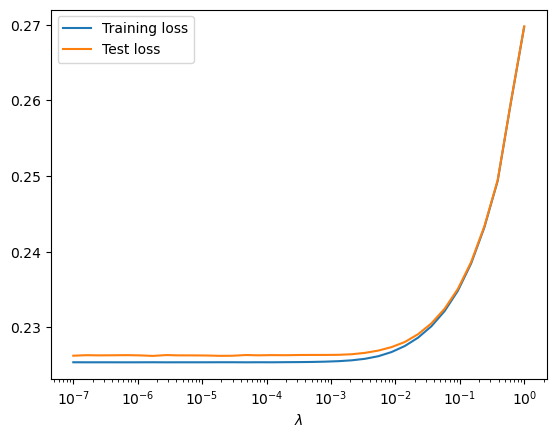

In [5]:
plt.plot(lambdas, losses_tr, label='Training loss')
plt.plot(lambdas, losses_te, label = 'Test loss')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.legend()
plt.savefig('Hyperparametertuning finetuned10e-7--10e0.png', dpi=369)

In [6]:
newpath = '.\\hyperparam_tuning\\max_iters_400_gamma_1_lams_logspace-7_0_35_k_6' 
save_array_as_csv(lambdas, 'lambdas', newpath)

In [7]:
# Find the best lambda    
best_lambda = lambdas[np.argmin(losses_te)]

### Training with best lambda, extra long!

In [9]:
lambda_ = best_lambda
# Set initial parameters
initial_w = np.zeros((tx.shape[1], 1))
max_iters = 100000  # Number of iterations
gamma = 0.5  # Learning rate

In [10]:
final_w, final_loss = reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma)

Current iteration=0, loss=0.6931471805600689
Current iteration=100, loss=0.22933462271261212
Current iteration=200, loss=0.22658520498308887
Current iteration=300, loss=0.2259742427307593
Current iteration=400, loss=0.22573875701115767
Current iteration=500, loss=0.22561708758832935
Current iteration=600, loss=0.22554202533267337
Current iteration=700, loss=0.22549061271886675
Current iteration=800, loss=0.2254531312434999
Current iteration=900, loss=0.22542469445214572
Current iteration=1000, loss=0.2254025045877077
Current iteration=1100, loss=0.2253848069252999
Current iteration=1200, loss=0.22537043129966303
Current iteration=1300, loss=0.2253585644806532
Current iteration=1400, loss=0.22534862480757661
Current iteration=1500, loss=0.22534018733586605
Current iteration=1600, loss=0.225332936395091
Current iteration=1700, loss=0.22532663419838844
Current iteration=1800, loss=0.22532109941737805
Current iteration=1900, loss=0.22531619221983223
Current iteration=2000, loss=0.225311803

### Safe results

In [92]:
path = '.\\final_results' 
name = 'resuts'
X_path = '..\\data\\x_test.csv'
y, _ = safe_results(final_w, X_path, path, name)